                Open      High       Low     Close  Volume_(BTC)  \
Timestamp                                                          
2011-12-31  4.465000  4.482500  4.465000  4.482500     23.829470   
2012-01-01  4.806667  4.806667  4.806667  4.806667      7.200667   
2012-01-02  5.000000  5.000000  5.000000  5.000000     19.048000   
2012-01-03  5.252500  5.252500  5.252500  5.252500     11.004660   
2012-01-04  5.200000  5.223333  5.200000  5.223333     11.914807   

            Volume_(Currency)  Weighted_Price  
Timestamp                                      
2011-12-31         106.330084        4.471603  
2012-01-01          35.259720        4.806667  
2012-01-02          95.240000        5.000000  
2012-01-03          58.100651        5.252500  
2012-01-04          63.119577        5.208159  
(3379, 7)
<bound method DataFrame.info of                     Open          High           Low         Close  \
Timestamp                                                            
2011-

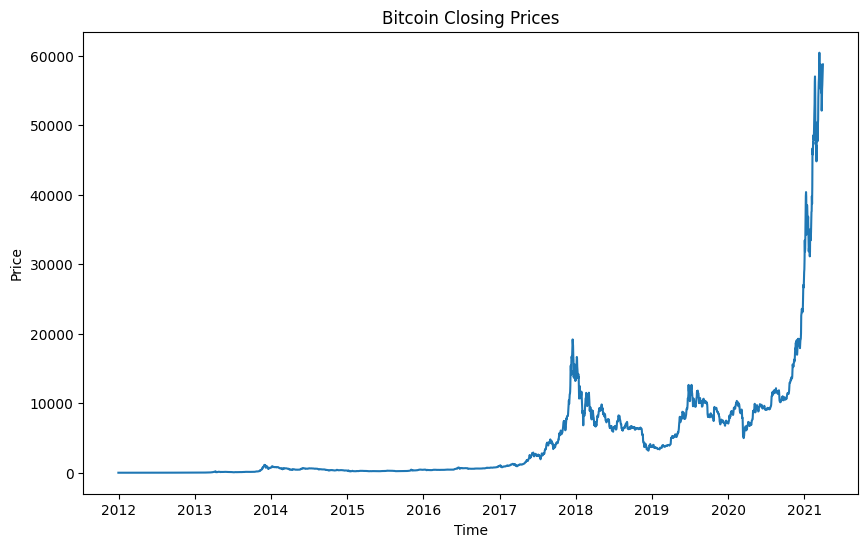

Null data points (before): 

Open                 3
High                 3
Low                  3
Close                3
Volume_(BTC)         3
Volume_(Currency)    3
Weighted_Price       3
dtype: int64
Null data points (after interpolation): 

Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt

# Load and preprocess the data
# load data
data = pd.read_csv('/content/drive/MyDrive/Datasets/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

# convert timestamp into dates
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
data = data.set_index('Timestamp') # to resample
data = data.resample('D').mean() # resampling to daily freq

# data inspection
print(data.head(5))
print(data.shape)
print(data.info)

# line plot of data
plt.figure(figsize=(10, 6))
plt.plot(data['Close'])
plt.title('Bitcoin Closing Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

# to handle missing data, we use linear interpolation
# which assumes linearity between data points and utilizes non-missing values from adjacent data points to compute a value for a missing data point.
print("Null data points (before): \n")
print(data.isnull().sum()) # before interpolation

data['Open'] = data['Open'].interpolate()
data['Close'] = data['Close'].interpolate()
data['Weighted_Price'] = data['Weighted_Price'].interpolate()
data['Volume_(BTC)'] = data['Volume_(BTC)'].interpolate()
data['Volume_(Currency)'] = data['Volume_(Currency)'].interpolate()
data['High'] = data['High'].interpolate()
data['Low'] = data['Low'].interpolate()

print("Null data points (after interpolation): \n")
print(data.isnull().sum()) # after interpolation

In [ ]:
# Feature Selection
# calculate the correlation coefficients
correlations = data.corrwith(data['Close']).abs()

# select top k features
k = 4 # (top 3, but correlations contains close as well, which we want to include)
top_k_features = correlations.nlargest(k).index.tolist()
print(f"Top {k} features: {top_k_features}")
features = top_k_features
data_multi = data[features]

# normalizing data
scaler_multi = MinMaxScaler()
data_scaled_multi = scaler_multi.fit_transform(data_multi)

def create_dataset_multi(data, features, look_back):
    # create X and Y that in LSTM input format (data, look back, #features)
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        Y.append(data[i + look_back, features.index('Close')])
    return np.array(X), np.array(Y)

look_back = 10 # last 10 days used for testing
X_multi, Y_multi = create_dataset_multi(data_scaled_multi, features, look_back)
print(X_multi.shape)
print(Y_multi.shape)

# split X and Y into train and test (0.8 train set, 0.2 test set)
train_size = int(len(X_multi) * 0.8)
X_train_multi, X_test_multi = X_multi[:train_size], X_multi[train_size:]
Y_train_multi, Y_test_multi = Y_multi[:train_size], Y_multi[train_size:]

# reshape to input into LSTM
X_train_multi = np.reshape(X_train_multi, (X_train_multi.shape[0], look_back, X_train_multi.shape[2]))
X_test_multi = np.reshape(X_test_multi, (X_test_multi.shape[0], look_back, X_test_multi.shape[2]))
print(X_train_multi.shape)
print(X_test_multi.shape)

Top 4 features: ['Close', 'Open', 'Weighted_Price', 'High']
(3369, 10, 4)
(3369,)
(2695, 10, 4)
(674, 10, 4)


In [ ]:
# Build LSTM models
# baseline
model1_multi = Sequential()
model1_multi.add(LSTM(10, input_shape=(X_train_multi.shape[1], X_train_multi.shape[2])))
model1_multi.add(Dense(1))
model1_multi.compile(loss='mean_squared_error', optimizer='rmsprop')
model1_multi.fit(X_train_multi, Y_train_multi, epochs=16, batch_size=1, verbose=2, validation_split=0.1) # 10% val set

# improved (added dropout layer to avoid overfitting and added more units to first layer to 50)
# changed optimizer to adam
model2_multi = Sequential()
model2_multi.add(LSTM(50, input_shape=(X_train_multi.shape[1], X_train_multi.shape[2])))
model2_multi.add(Dropout(0.2))
model2_multi.add(Dense(1))
model2_multi.compile(loss='mean_squared_error', optimizer='adam')
model2_multi.fit(X_train_multi, Y_train_multi, epochs=16, batch_size=1, verbose=2, validation_split=0.1) # 10% val set

models_multi = [model1_multi, model2_multi]

Epoch 1/16
2425/2425 - 14s - loss: 3.0505e-04 - val_loss: 2.7708e-05 - 14s/epoch - 6ms/step
Epoch 2/16
2425/2425 - 8s - loss: 4.8059e-05 - val_loss: 2.2194e-05 - 8s/epoch - 3ms/step
Epoch 3/16
2425/2425 - 10s - loss: 4.1882e-05 - val_loss: 7.7609e-05 - 10s/epoch - 4ms/step
Epoch 4/16
2425/2425 - 10s - loss: 3.4768e-05 - val_loss: 2.5569e-05 - 10s/epoch - 4ms/step
Epoch 5/16
2425/2425 - 8s - loss: 3.0339e-05 - val_loss: 2.9724e-05 - 8s/epoch - 3ms/step
Epoch 6/16
2425/2425 - 9s - loss: 2.6584e-05 - val_loss: 1.3160e-05 - 9s/epoch - 4ms/step
Epoch 7/16
2425/2425 - 8s - loss: 2.5457e-05 - val_loss: 2.1123e-05 - 8s/epoch - 3ms/step
Epoch 8/16
2425/2425 - 9s - loss: 2.3296e-05 - val_loss: 1.4484e-05 - 9s/epoch - 4ms/step
Epoch 9/16
2425/2425 - 9s - loss: 2.2130e-05 - val_loss: 1.0884e-05 - 9s/epoch - 4ms/step
Epoch 10/16
2425/2425 - 8s - loss: 2.0974e-05 - val_loss: 3.2498e-05 - 8s/epoch - 3ms/step
Epoch 11/16
2425/2425 - 11s - loss: 2.0000e-05 - val_loss: 1.4692e-05 - 11s/epoch - 4ms/step


Model:1
Train Score: 0.00001 MSE
Test Score: 0.00119 MSE
22/22 [==============================] - 0s 3ms/step


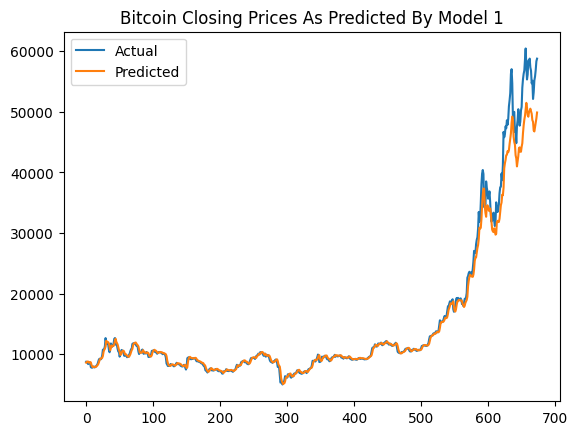

Model:2
Train Score: 0.00004 MSE
Test Score: 0.00036 MSE
22/22 [==============================] - 0s 4ms/step


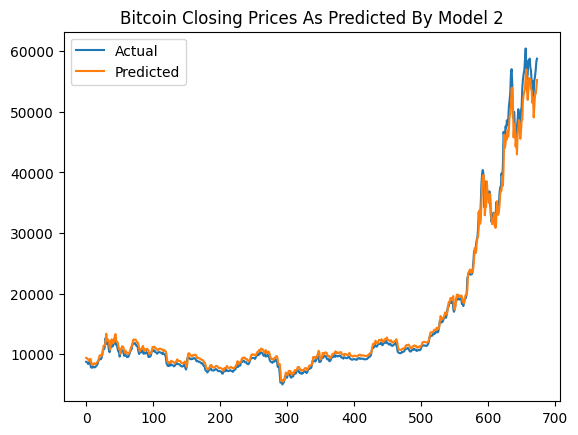

In [ ]:
# Evaluate models
for i in range(len(models_multi)):
    model = models_multi[i]

    print("Model:" + str(i+1))
    # get scores
    train_score = model.evaluate(X_train_multi, Y_train_multi, verbose=0)
    test_score = model.evaluate(X_test_multi, Y_test_multi, verbose=0)
    print(f'Train Score: {train_score:.5f} MSE')
    print(f'Test Score: {test_score:.5f} MSE')

    # make predictions
    Y_train_pred_multi = model.predict(X_train_multi)
    Y_test_pred_multi = model.predict(X_test_multi)

    # revert scaling
    Y_train_pred_multi = scaler_multi.inverse_transform(np.hstack([Y_train_pred_multi, np.zeros((Y_train_pred_multi.shape[0], len(features) - 1))]))[:, 0]
    Y_test_pred_multi = scaler_multi.inverse_transform(np.hstack([Y_test_pred_multi, np.zeros((Y_test_pred_multi.shape[0], len(features) - 1))]))[:, 0]
    Y_train_2_multi = scaler_multi.inverse_transform(np.hstack([Y_train_multi.reshape(-1, 1), np.zeros((Y_train_multi.shape[0], len(features) - 1))]))[:, 0]
    Y_test_2_multi = scaler_multi.inverse_transform(np.hstack([Y_test_multi.reshape(-1, 1), np.zeros((Y_test_multi.shape[0], len(features) - 1))]))[:, 0]

    # plot predictions
    plt.plot(Y_test_2_multi, label='Actual')
    plt.plot(Y_test_pred_multi, label='Predicted')
    plt.legend()
    plt.title("Bitcoin Closing Prices As Predicted By Model " + str(i+1))
    plt.show()